# Extending A/B test with Double Machine Learning

This post will explore the strengths of A/B testing and introduce Double Machine Learning (DoubleML) as a powerful technique for addressing confounding variables. I will demonstrate how DoubleML can provide a more robust estimate of the treatment effect by effectively controlling for confounders. The key takeaway is to show how DoubleML can help ensure your results are more accurate and reliable.

This is a case study of a bank trying to increase their Certificate of Deposit (CD). A bank, concerned about its low rate of CD subscriptions, initiated a randomized marketing study. Historically, its overall customer CD uptake was 13%. From its customer base, 25,000 individuals were selected using stratified sampling to ensure a representative group.

Approximately 40% of this sample was randomly assigned to a treatment group. This group received a targeted campaign: a push notification or text message offering a CD with a higher-than-usual return rate. The bank's management hypothesized that this promotion would significantly increase CD uptake. If the results were positive, the plan was to roll the program out to all existing and potential customers.

Import libraries and file

In [28]:
library(readr)
library(tidyverse)
cust_data <- read_csv("cust_data.csv")

Rows: 25000 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): treated
dbl (6): mobile_bank, income, saving_account, mobile_bank_new, CD_existing, CD_new

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The dataset has 9 columns. The column of interest is the CD_new. The treated column shows those who got the offer or not. 

In [29]:
head(cust_data)

# A tibble: 6 × 7
  mobile_bank income saving_account treated  mobile_bank_new CD_existing CD_new
        <dbl>  <dbl>          <dbl> <chr>              <dbl>       <dbl>  <dbl>
1           1 133856         60250. Offer                  1           1      1
2           1 253744        121303. No Offer               1           1      1
3           1 121063         54653. No Offer               1           1      1
4           1      0          3049. Offer                  1           0      0
5           1      0          2542. Offer                  1           0      0
6           1  54809          3297. No Offer               1           0      0

In [30]:
str(cust_data)

spc_tbl_ [25,000 × 7] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ mobile_bank    : num [1:25000] 1 1 1 1 1 1 0 0 1 1 ...
 $ income         : num [1:25000] 133856 253744 121063 0 0 ...
 $ saving_account : num [1:25000] 60250 121303 54653 3049 2542 ...
 $ treated        : chr [1:25000] "Offer" "No Offer" "No Offer" "Offer" ...
 $ mobile_bank_new: num [1:25000] 1 1 1 1 1 1 0 1 1 1 ...
 $ CD_existing    : num [1:25000] 1 1 1 0 0 0 0 1 0 1 ...
 $ CD_new         : num [1:25000] 1 1 1 0 0 0 1 0 0 1 ...
 - attr(*, "spec")=
  .. cols(
  ..   mobile_bank = col_double(),
  ..   income = col_double(),
  ..   saving_account = col_double(),
  ..   treated = col_character(),
  ..   mobile_bank_new = col_double(),
  ..   CD_existing = col_double(),
  ..   CD_new = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [31]:
summary(cust_data)

  mobile_bank         income       saving_account       treated          mobile_bank_new  CD_existing         CD_new      
 Min.   :0.0000   Min.   :     0   Min.   :  -303.8   Length:25000       Min.   :0.00    Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1.0000   1st Qu.:106219   1st Qu.:  3312.3   Class :character   1st Qu.:1.00    1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1.0000   Median :143361   Median : 48382.2   Mode  :character   Median :1.00    Median :0.0000   Median :0.0000  
 Mean   :0.8007   Mean   :125462   Mean   : 43065.9                      Mean   :0.83    Mean   :0.3092   Mean   :0.3231  
 3rd Qu.:1.0000   3rd Qu.:169963   3rd Qu.: 68936.1                      3rd Qu.:1.00    3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :312983   Max.   :182080.2                      Max.   :1.00    Max.   :1.0000   Max.   :1.0000  

Let us see how the exisitng CD before the A/B test and CD after the test compares.

In [32]:
cat("Mean of CD_existing:", mean(cust_data$CD_existing)*100, 
    "\nMean of CD_new:", mean(cust_data$CD_new)*100, "\n")


Mean of CD_existing: 30.924 
Mean of CD_new: 32.312 


There is a 5 percent point improvement in the CD after the intervention. However, we are not sure if it's the causal effect of the offer, hence we can run an A/B test. 

In [33]:
cust_data$treated_encoded <- ifelse(cust_data$treated=="Offer",1,0)
cust_data$treated_encoded_t <- factor(cust_data$treated_encoded, levels = c(1, 0))
#A/B test result

t.test(CD_new ~ treated_encoded_t, data = cust_data, alternative = "greater")


	Welch Two Sample t-test

data:  CD_new by treated_encoded_t
t = 7.3557, df = 21009, p-value = 9.845e-14
alternative hypothesis: true difference in means between group 1 and group 0 is greater than 0
95 percent confidence interval:
 0.03465899        Inf
sample estimates:
mean in group 1 mean in group 0 
      0.3498356       0.3051935 


The initial analysis of the A/B test showed promising results. We can establish a causal estimate by comparing the average outcomes between the treatment and control groups, as the random assignment helps to neutralize the effects of other variables.
A t-test was performed to determine if the difference between the groups was statistically significant. The results were as follows:
Treatment Group: Had a CD subscription rate of 24%.
Control Group: Had a CD subscription rate of 5.6%.

The very low p-value and the confidence interval for the difference between the groups both indicate that the marketing program was highly effective.

### Some potential underlying problems

About 80% have mobile banking and past records suggest having mobile banking has correlation with also having a CD account.

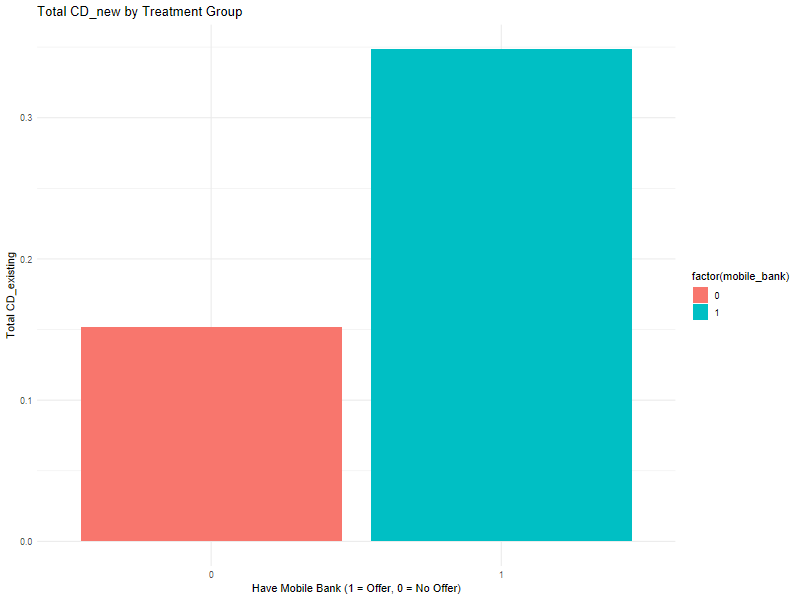

In [41]:
 ggplot(cust_data, aes(x = factor(mobile_bank), y = CD_existing,fill = factor(mobile_bank))) +
  geom_bar(stat="summary", fun=mean) +
  labs(title = "Total CD_new by Treatment Group",
       x = "Have Mobile Bank (1 = Offer, 0 = No Offer)",
       y = "Total CD_existing") +
  theme_minimal()

In [35]:
#CD accounts
cat("Mean of exsiting CD", mean(cust_data$CD_existing)*100,
        "\nMean of existing CD who have mobile bank", mean(cust_data$CD_existing[cust_data$mobile_bank==1]*100),
        "\nMean of existing CD who do not have mobile bank", mean(cust_data$CD_existing[cust_data$mobile_bank==0]*100)) 


Mean of exsiting CD 30.924 
Mean of existing CD who have mobile bank 34.84364 
Mean of existing CD who do not have mobile bank 15.17463

In [36]:
#CD_new accounts
cat("Mean of new CD",mean(cust_data$CD_new),
"\nMean of new CD who have mobile bank", mean(cust_data$CD_new[cust_data$mobile_bank_new==1]),
"\nMean of new CD who do not have mobile bank",mean(cust_data$CD_new[cust_data$mobile_bank_new==0]))

Mean of new CD 0.32312 
Mean of new CD who have mobile bank 0.3611258 
Mean of new CD who do not have mobile bank 0.1376147

## Double Machine Learning

To isolate the promotion's effect from other variables and get a more accurate estimate of its true impact, we can use a method called Double Machine Learning (DML). Unlike a simple comparison of means, DML actively uses information about potential confounders. Fortunately, we have identified several important confounders related to CD accounts that we can use to build our DML model.

First, we build a model to predict the outcome (opening a new CD account) using only the confounding variables (e.g., savings, income, mobile banking use, existing CD status). Since the outcome is binary (yes/no), a logistic regression is a good choice,

In [37]:
#predict outcome from confounders

lm_outcome <- glm(CD_new ~ mobile_bank_new + income + saving_account + CD_existing, 
                     data = cust_data, family = binomial(link = "logit"))
summary(lm_outcome)


Call:
glm(formula = CD_new ~ mobile_bank_new + income + saving_account + 
    CD_existing, family = binomial(link = "logit"), data = cust_data)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -5.407e+00  9.096e-02 -59.437   <2e-16 ***
mobile_bank_new  1.638e+00  5.775e-02  28.373   <2e-16 ***
income           1.320e-06  5.508e-07   2.396   0.0166 *  
saving_account   5.046e-05  1.072e-06  47.065   <2e-16 ***
CD_existing      1.005e+00  3.874e-02  25.956   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31460  on 24999  degrees of freedom
Residual deviance: 18758  on 24995  degrees of freedom
AIC: 18768

Number of Fisher Scoring iterations: 6


Next, we build a second model. This time, we predict the treatment assignment (i.e., who received the promotion) using the same set of confounding variables.

In [42]:
#predict treatment from confounders
lm_treatment <- glm(treated_encoded ~ mobile_bank_new + income + saving_account + CD_existing, 
                     data = cust_data, family = binomial(link = "logit"))
summary(lm_treatment)


Call:
glm(formula = treated_encoded ~ mobile_bank_new + income + saving_account + 
    CD_existing, family = binomial(link = "logit"), data = cust_data)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -4.336e-01  3.990e-02 -10.869   <2e-16 ***
mobile_bank_new -1.234e-02  3.494e-02  -0.353    0.724    
income           3.463e-07  2.481e-07   1.396    0.163    
saving_account   4.135e-07  5.618e-07   0.736    0.462    
CD_existing     -5.322e-02  3.476e-02  -1.531    0.126    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 33682  on 24999  degrees of freedom
Residual deviance: 33676  on 24995  degrees of freedom
AIC: 33686

Number of Fisher Scoring iterations: 4


Now, the residual of both the models are recorded. This helps isloate the variable not explained by confounders

In [43]:
#calculate residuals
residuals_outcome <- resid(lm_outcome, type = "response")
residuals_treatment <- resid(lm_treatment, type = "response")

We run a simple linear regression using these residuals:

In [44]:
#Causal Effect
causal_effect <- lm(residuals_outcome ~ residuals_treatment)
summary(causal_effect)


Call:
lm(formula = residuals_outcome ~ residuals_treatment)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.01702 -0.13149 -0.01404  0.19273  0.96355 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -2.972e-15  2.202e-03   0.000        1    
residuals_treatment  4.414e-02  4.493e-03   9.823   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3482 on 24998 degrees of freedom
Multiple R-squared:  0.003845,	Adjusted R-squared:  0.003805 
F-statistic: 96.49 on 1 and 24998 DF,  p-value: < 2.2e-16


After controlling for customer characteristics like mobile banking habits and savings levels, the model confirms the promotion has a statistically significant causal effect, increasing CD uptake by approximately 4.4%.

This shows that treatment on average has 4.4 % impact on the outcome of CD. This is down from 5% we saw initially. The DML helped seperate the impact of savings, incomes and mobile banking that had impact on opening CD.